## **Import Required Libraries**

In [1]:
import pandas as pd # Data manipulation
import numpy as np # Numerical operations
import matplotlib.pyplot as plt # Data visualization
import seaborn as sns # Statistical data visualization

# Machine learning libraries
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder # Data preprocessing
from sklearn.compose import ColumnTransformer # Column transformations


## **Data Preparation and Preprocessing**

### **1. Load Data**

In [2]:
# Load the dataset
data = pd.read_csv('car_price_prediction.csv')
data.head()

,Car ID,Brand,Year,Engine Size,Fuel Type,Transmission,Mileage,Condition,Price,Model
0,1,Tesla,2016,2.3,Petrol,Manual,114832,New,26613.92,Model X
1,2,BMW,2018,4.4,Electric,Manual,143190,Used,14679.61,5 Series
2,3,Audi,2013,4.5,Electric,Manual,181601,New,44402.61,A4
3,4,Tesla,2011,4.1,Diesel,Automatic,68682,New,86374.33,Model Y
4,5,Ford,2009,2.6,Diesel,Manual,223009,Like New,73577.10,Mustang


In [3]:
# Dataset shape
data.shape

(2500, 10)

In [4]:
# Check for data types and non-null counts
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Car ID        2500 non-null   int64  
 1   Brand         2500 non-null   object 
 2   Year          2500 non-null   int64  
 3   Engine Size   2500 non-null   float64
 4   Fuel Type     2500 non-null   object 
 5   Transmission  2500 non-null   object 
 6   Mileage       2500 non-null   int64  
 7   Condition     2500 non-null   object 
 8   Price         2500 non-null   float64
 9   Model         2500 non-null   object 
dtypes: float64(2), int64(3), object(5)
memory usage: 195.4+ KB


- This dataset contains 2500 car records with 10 attributes describing each vehicle. The columns include details such as the car's brand, model, manufacturing year, engine size, fuel type, transmission type, mileage, condition, and price. All entries are complete with no missing values.

### **2. Data Cleaning**

In [5]:
data.columns = (
    data.columns
    .str.strip()
    .str.title()
    .str.replace(" ", "_")
    .str.replace("-", "_")
)
data.head()

,Car_Id,Brand,Year,Engine_Size,Fuel_Type,Transmission,Mileage,Condition,Price,Model
0,1,Tesla,2016,2.3,Petrol,Manual,114832,New,26613.92,Model X
1,2,BMW,2018,4.4,Electric,Manual,143190,Used,14679.61,5 Series
2,3,Audi,2013,4.5,Electric,Manual,181601,New,44402.61,A4
3,4,Tesla,2011,4.1,Diesel,Automatic,68682,New,86374.33,Model Y
4,5,Ford,2009,2.6,Diesel,Manual,223009,Like New,73577.10,Mustang


In [6]:
# Check for missing values
data.isna().sum()

Car_Id          0
Brand           0
Year            0
Engine_Size     0
Fuel_Type       0
Transmission    0
Mileage         0
Condition       0
Price           0
Model           0
dtype: int64

In [7]:
# Remove identifier columns
data = data.drop_duplicates()
data.shape

(2500, 10)

In [8]:
# Remove 'Car ID' column if it exists
data = data.drop(columns=['Car ID'], errors='ignore')

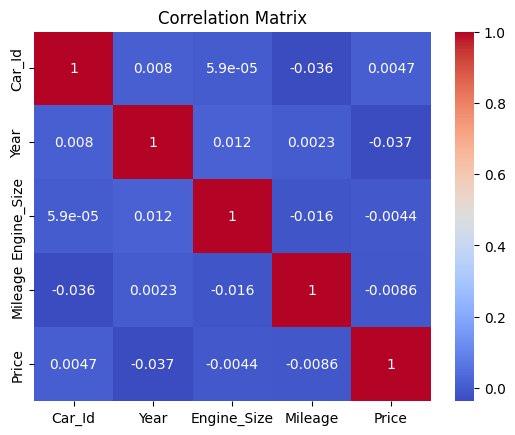

In [9]:
# Correlation matrix heatmap
numeric_df = data.select_dtypes(include=["int64", "float64"])
corr_matrix = numeric_df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

## **Outlier Ditection and Removing**

C:\Users\ROG\AppData\Local\Temp\ipykernel_17120\309111774.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([data[col] for col in numeric_cols], labels=numeric_cols)


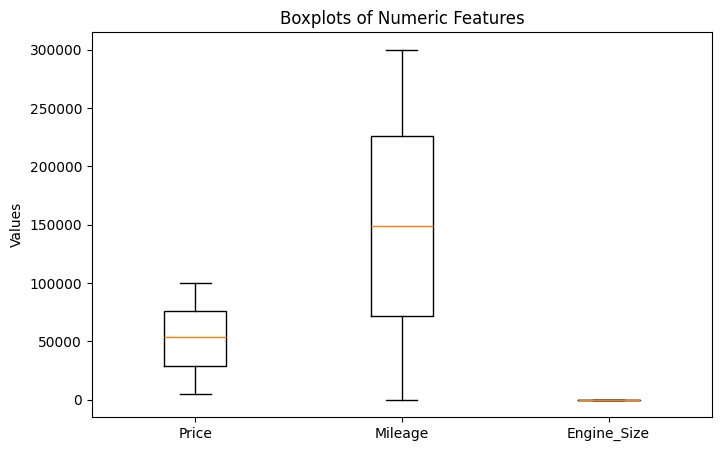

In [10]:
# Visualization of outliers using boxplots
numeric_cols = ["Price", "Mileage", "Engine_Size"]

plt.figure(figsize=(8, 5))
plt.boxplot([data[col] for col in numeric_cols], labels=numeric_cols)
plt.title("Boxplots of Numeric Features")
plt.ylabel("Values")
plt.show()

In [11]:
# Function to remove outliers using IQR method
def remove_outliers_iqr(df, columns):
    df_clean = df.copy()
    for col in columns:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1

        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR

        df_clean = df_clean[(df_clean[col] >= lower) & (df_clean[col] <= upper)]
    return df_clean

In [12]:
numeric_for_outlier = ["Price", "Mileage", "Engine_Size"]
df = remove_outliers_iqr(data, numeric_for_outlier)
print("Shape after outlier removal:", df.shape)

Shape after outlier removal: (2500, 10)


C:\Users\ROG\AppData\Local\Temp\ipykernel_17120\1004734373.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([data[col] for col in numeric_cols], labels=numeric_cols)


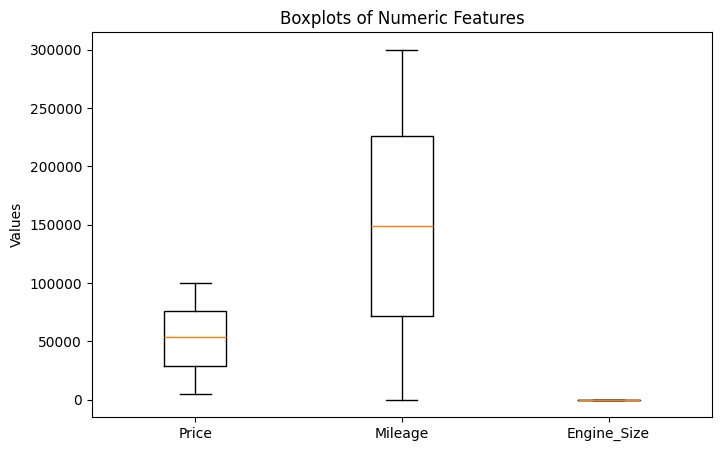

In [13]:
# Visualization of outliers using boxplots after outlier removal
numeric_cols = ["Price", "Mileage", "Engine_Size"]

plt.figure(figsize=(8, 5))
plt.boxplot([data[col] for col in numeric_cols], labels=numeric_cols)
plt.title("Boxplots of Numeric Features")
plt.ylabel("Values")
plt.show()

## **Feature Engineering**

In [14]:
# Feature Engineering: Create 'Vehicle_Age' from 'Year'
if "Year" in df.columns:
    df["Vehicle_Age"] = 2025 - df["Year"]
    df = df.drop("Year", axis=1)

In [15]:
# Define target and features
X = df.drop("Price", axis=1)
y = df["Price"]

In [16]:
# Define feature types
numeric_features = ["Mileage", "Engine_Size", "Vehicle_Age"]
categorical_nominal = ["Brand", "Fuel_Type", "Transmission"]
categorical_ordinal = ["Condition"]   # Ordered: New > Like New > Used

In [17]:
# Ordinal mapping
condition_order = [["Used", "Like New", "New"]]

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        # Standardize numeric features
        ("num", StandardScaler(), numeric_features),
        # One-hot encode nominal categorical features
        ("nominal", OneHotEncoder(handle_unknown='ignore'),
            categorical_nominal),
        # Ordinal encode ordinal categorical features
        ("ordinal", OrdinalEncoder(categories=condition_order),
            categorical_ordinal)
    ]
)

In [ ]:
# Apply preprocessing
X_processed = preprocessor.fit_transform(X)
X_processed

array([[-0.39723441, -0.8138477 , -0.6256096 , ...,  0.        ,
         1.        ,  2.        ],
       [-0.07462649,  0.65287175, -0.91172027, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.36234696,  0.72271553, -0.19644359, ...,  0.        ,
         1.        ,  2.        ],
       ...,
       [ 1.40015747, -1.65197311, -1.34088628, ...,  0.        ,
         1.        ,  1.        ],
       [ 0.90343592,  0.72271553,  1.37716511, ...,  0.        ,
         1.        ,  1.        ],
       [-0.78236625,  0.79255932,  0.9479991 , ...,  1.        ,
         0.        ,  0.        ]], shape=(2500, 17))